In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression


## Data Preprocessing and Prepration

In [40]:
csv_data = pd.read_csv('Disease Prediction Training.csv')
csv_data.shape

(49000, 12)

We can see that the datarame has 49000 rows and 12 columns

The describe function gives summary statistics of all numeric columns in the data

In [41]:
csv_data.describe()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease
count,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000,49000.000000
mean,52.853306,164.366878,74.190527,128.698939,96.917367,0.088265,0.054245,0.803204,0.499959
std,6.763065,8.216637,14.329934,147.624582,200.368069,0.283683,0.226503,0.397581,0.500005
min,29.000000,55.000000,10.000000,-150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,207.000000,200.000000,14020.000000,11000.000000,1.000000,1.000000,1.000000,1.000000


###### Null values in each column and datatype of each column

In [42]:
#check null values in each column
csv_data.isna().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

In [43]:
#datatype of all attributes in the dataframe
csv_data.dtypes


Age                      int64
Gender                  object
Height                   int64
Weight                 float64
High Blood Pressure      int64
Low Blood Pressure       int64
Cholesterol             object
Glucose                 object
Smoke                    int64
Alcohol                  int64
Exercise                 int64
Disease                  int64
dtype: object

There are no null values in the data that need to be interpolated but it doesn't mean that the data can be transformed and used for model building. There is a possibility that numeric data columns contain outliers and it is important to replace them before using that data for building models.

###### Number of unique values in each column

In [44]:
#number of unique values in each colum
for col in csv_data.columns:
    print(col, len(set(csv_data[col])))
    if len(set(csv_data[col]))<5:
        print(set(csv_data[col]))

Age 28
Gender 2
{'male', 'female'}
Height 101
Weight 248
High Blood Pressure 143
Low Blood Pressure 143
Cholesterol 3
{'too high', 'normal', 'high'}
Glucose 3
{'too high', 'normal', 'high'}
Smoke 2
{0, 1}
Alcohol 2
{0, 1}
Exercise 2
{0, 1}
Disease 2
{0, 1}


We can infer from the number of unique values in each column that Smoke, Alcohol, Exercise and Disease are actually dichotomous variables taking values 0 and 1

#### Outlier Detection

Age
min:  29
max:  64


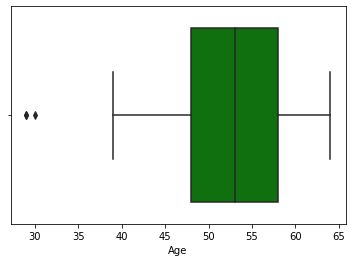

Height
min:  55
max:  207


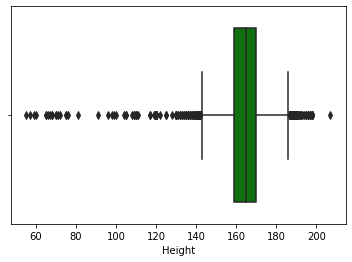

Weight
min:  10.0
max:  200.0


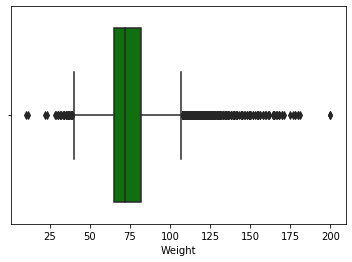

High Blood Pressure
min:  -150
max:  14020


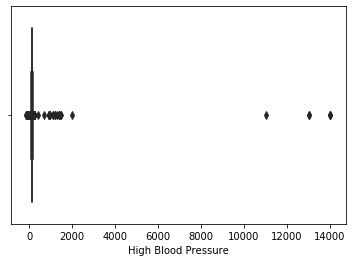

Low Blood Pressure
min:  0
max:  11000


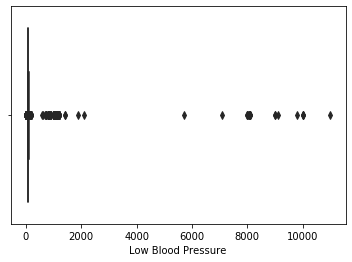

In [45]:
col_num = ['Age','Height','Weight','High Blood Pressure','Low Blood Pressure']
for col in col_num:
    if csv_data[col].dtypes == np.float64 or csv_data[col].dtypes == np.int64:
        print(col)
        print("min: ", min(csv_data[col]))
        print("max: ", max(csv_data[col]))
        sn.boxplot(x=col, data = csv_data,color = 'green')
        plt.show()

There are many things that can be iferred from the above cell output. These are:
<br>
1) The min age is 29 and max is 64, although the value for age varaible is centered aroud 40 and 65 and as there is nothing mentioned about the disease in question so we cannot rule out the possibility of a person of younger age getting the disease. It would be rare but still possible and thus, we won't replace outlies i.e. less than 35 for age variable
<br>
2) max height recorded in world is 251cm and min height recorded is 54.64cm and the max and min height recorded in the data are 55cm and 207cm thus, it is possible that these values are not actually outliers insted they show the presence of pretty short and tall people.
<br>
3) As we know the min height in dataset is 55 cm and min age is 29 it is not possible to have an individual with weight of 10kgs. The min weight for adults is usually around 40kgs and thus, we need to interpolate these values with median. Median is choosen for interpolation as mean is sensetive to outliers. Weight above 180kgs is a possibility. Max weight for an individual is recorded as 357 kgs and thus, values above 180kgs shouldn't be treated as outliers, insted these values make sure that rare cases are considered in the data while building models
<br>
4) For High Blood Pressure the min value in the data is -150 and max is 14020 which is not technically possible. Usually 180+ High Blood Pressure is considered as hypertensive crisis. Also, according to a research the highest mean BP recorded was 190/175 mg thus, it is safe to consider any High BP values above 200 as an outlier and lower than 80 as an outlier. Outliers can again be replaced with median value
<br>
5) For Low Blood Pressure the min value in the data is 0 and max is 11000 which is not technically possible.As discussed above it is safe to assume the hightest Low Blood Pressure as 175 mg and the lowest as 40. All the values outside this range should be treated as outlier and should be interpolated. 

In [46]:
median_HBP = csv_data['High Blood Pressure'].median()
median_LBP = csv_data['Low Blood Pressure'].median()
median_weight = csv_data['Weight'].median()
csv_data.loc[(csv_data['High Blood Pressure']>200),'High Blood Pressure'] = median_HBP
csv_data.loc[(csv_data['High Blood Pressure']<80),'High Blood Pressure'] = median_HBP
csv_data.loc[(csv_data['Low Blood Pressure']>175),'Low Blood Pressure'] = median_LBP
csv_data.loc[(csv_data['Low Blood Pressure']<40),'Low Blood Pressure'] = median_LBP
csv_data.loc[(csv_data['Weight']<40),'Weight'] = median_weight

After replacing the outliers in the data there are still some discrepencies that can occur such as the value of High Blood Pressure is lower than the value of Low Blood Pressure which is not really possible. Thus, it is important to remove these columns. There are 63 such coluns

In [47]:
csv_data[csv_data['High Blood Pressure']<csv_data['Low Blood Pressure']]
csv_data.drop(csv_data[csv_data['High Blood Pressure']<csv_data['Low Blood Pressure']].index, inplace = True, axis =0)

## Data Vizualizations

There are many questions that can be answered by plotting graphs and which might give us intresting insights about the data

#### How balanced is the data?

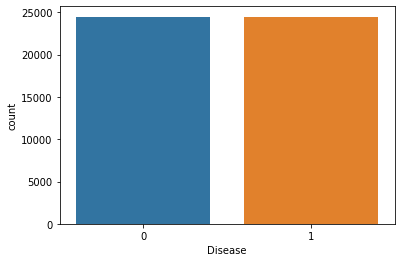

In [48]:
ax = sn.countplot(x ='Disease',data=csv_data)

The data is balanced in respect to the target variable i.e the number of people in the sample who don't suffer from a disease is almost equal to the number of people who suffer from the disease




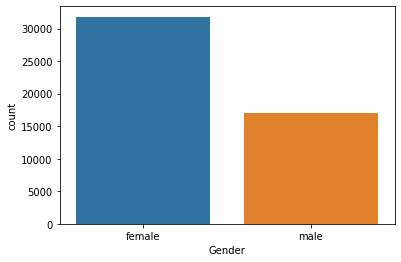

In [49]:
sn.countplot(x ='Gender',data=csv_data)

#### Feature transformation

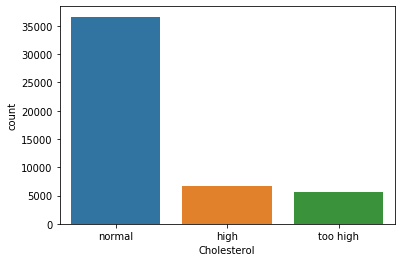

In [50]:
sn.countplot(x ='Cholesterol',data=csv_data)

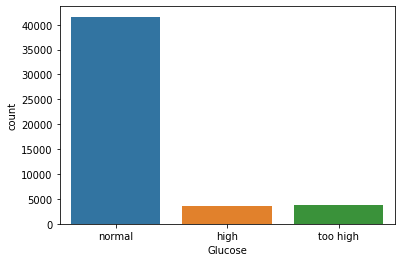

In [51]:
sn.countplot(x ='Glucose',data=csv_data)


<br>

We can observe a imbalance in data with respect to the categorical variables Glucose, Cholestrol and Gender. Especially Glusocose and Cholestrol are highly imbalanced it would be intreting to see if these values of Glucose and Cholestrol which are low in number directly impact the possibility of person suffering with disease. In other words Does high Glucose or Cholestrol garuntee that person will catch the disease? 

##### Impact of Cholesterol, Glucose and Gender on Disease

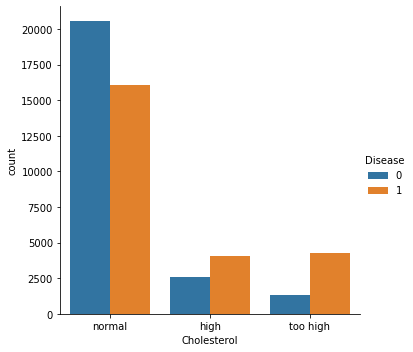

In [52]:
sn.catplot( x = "Cholesterol",kind="count",data = csv_data,hue="Disease")

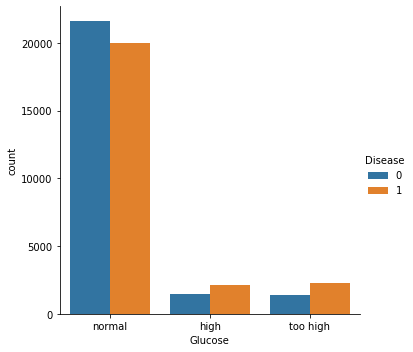

In [53]:
sn.catplot( x = "Glucose",kind="count",data = csv_data,hue="Disease")

Presence of high or too high Glucose and Cholestrol does increase the chances that a person sufferes from the disease. We can see 60% of people with high Cholestrol and 75% of people with too high Cholestrol do suffer from the disease

For Glucose, 55% people with high glucose and 65% people with too high glucose suffer from the disease

#### Impact of smoking and Alcohol Consuption on probability of person suffering with Disease. 

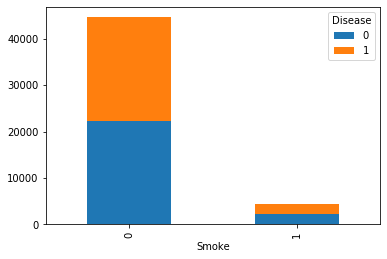

In [54]:
pd.crosstab(csv_data['Smoke'], csv_data['Disease']).plot(kind='bar', stacked=True)

Almost 91% of people present in the sample don't smoke and 50% of these people suffer with the disease in question. Similarly from the 9% people in sample smoke 55% of these people don't suffer from the disease

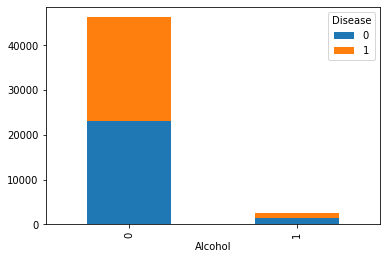

In [55]:
pd.crosstab(csv_data['Alcohol'], csv_data['Disease']).plot(kind='bar', stacked=True)

Almost 95% of people present in the sample don't drink alcohol and 50% of these people suffer with the disease in question. Similarly from the 5% people in sample drink alcohol and 50% of these people don't suffer from the disease. 

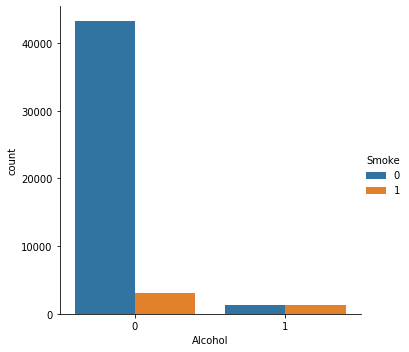

In [56]:
sn.catplot( x = "Alcohol",kind="count",data = csv_data,hue="Smoke")

From 95%(46k) of people in the sample who don't consume alcohol approximately, 10%(4.5k) of these people smoke while from 5%(3k)of people in the sample who consume alcohol approximately 50%(1.5k) of these people also smoke

#### Impact of Blood Pressure

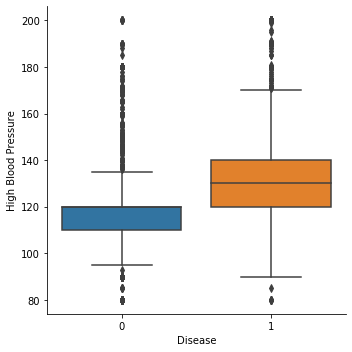

In [57]:
sn.catplot(x = "Disease", y = "High Blood Pressure",data = csv_data,kind ="box")

The plot above shows the box plot for High Blood Pressure for people suffering from disease and not suffering from disease. It is evident that people who suffer from the disease mostly have High Blood Pressure value above 120

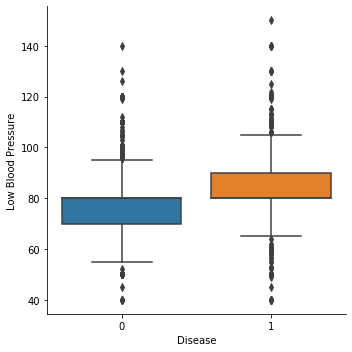

In [58]:
sn.catplot(x = "Disease", y = "Low Blood Pressure",data = csv_data,kind ="box")

The plot above shows the box plot for Low Blood Pressure for people suffering from disease and not suffering from disease. It is evident that people who suffer from the disease mostly have Low Blood Pressure value above 80

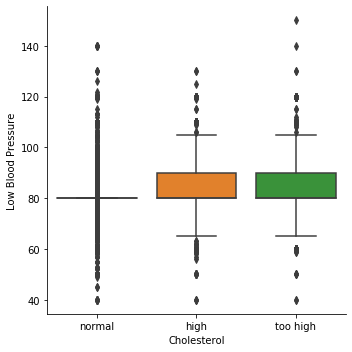

In [59]:
sn.catplot(x = "Cholesterol", y = "Low Blood Pressure",data = csv_data,kind ="box")

Usually people who have high and too high Cholestrol have Low Blood Pressure greater than 80

#### Feature transformation

##### Training and testing datasets

Split data into training and testing dataset. Stratify sampling will ensure that the ratio values in specified column remains same in training and testing data set as population data. i.e divide a population into homogeneous subpopulations called strata (the plural of stratum) based on specific characteristics in this case Disease

In [60]:
X = csv_data[csv_data.columns.difference(['Disease'])]
Y = csv_data['Disease']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state = 50)

##### Numerization of Categorical variable 

All the algorithms  take numeric data as input thus, it is important to convert the categorical data into numeric form. While the Label Encoding i.e. converting each categorical variable into ordinal works good with tree based model the distance based model such as Logistic Regression don't perform as expected and thus, for them it is best to use One Hot Encoder i.e dummy varaibles

In [61]:
oe = OneHotEncoder(handle_unknown="ignore",sparse=False)
le = LabelEncoder()

###### Label Encoding for tree based models

In [62]:
le_data = csv_data.copy()
oh_data =  csv_data.copy()
for col in le_data.columns:
    if le_data[col].dtypes == np.object:
        print(col)
        le_data[col] = le_data[col].astype(str)
        csv_le = le.fit(le_data[col])
        le_data[col] = csv_le.transform(le_data[col])

Gender
Cholesterol
Glucose


In [63]:
cat_features = ['Cholesterol', 'Gender', 'Glucose','Smoke','Alcohol','Exercise']
num_features = [x for x in X.columns if x not in cat_features]

categorical_transformer = Pipeline(steps=[("ohe",oe)])

numeric_transformer = Pipeline(steps=[("mms",StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])


oh_ss_pc = Pipeline(steps=[("preprocessor",preprocessor),("pca",PCA(n_components=10))])

In [64]:
X_train_std = oh_ss_pc.fit_transform(X_train)
X_test_std = oh_ss_pc.transform(X_test)

Train Test data for tree based and probability based classifiers 

In [75]:
X_le = le_data[le_data.columns.difference(['Disease'])]
Y_le = le_data['Disease']
X_train_le,X_test_le,y_train_le,y_test_le = train_test_split(X_le,Y_le,test_size=0.2,stratify=Y,random_state = 50)
numeric_transformer = Pipeline(steps=[("mms",StandardScaler())])
X_train_le = numeric_transformer.fit_transform(X_train_le)
X_test_le = numeric_transformer.transform(X_test_le)

## Prediction Models

For each model there is a confusion matrix which gives us an idea about true positive true negatives false positive and false negative values. Also, there a classification report which gives precision recall and f-1 for each class along with accuracy for the model

For model evaluvation the best metrics according to our dataset and target variable is recall(tp/(tp+fn)). The target variable is to predict if a person is suffering from a disease or not here false negative values are very dangerous i.e. if a person is actually suffering from the disease but the model predicts otherwise so recall would be a better metrics as compared to precision. False positives are bad but not as bad as flase negatives. Also, the dataset seems balanced with respect to target variable so recall would be a better metrics as compared to f1 score.

Also, there is a ROC curve and AUC score for eligible models. AUC score represents how much the model is able to seprate or distinguish between two classes while ROC curve 

### Logistic Regression

In [143]:
lr=LogisticRegression()

param_grid = {'C':[0.01,0.1,1,0.001],
              'penalty':['l2'],
              'solver':['lbfgs','saga']
             }
gridnlr = GridSearchCV(lr,param_grid,cv=3)

gridnlr.fit(X_train_std,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 0.001], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [144]:
p = gridnlr.predict(X_test_std)
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      4896
           1       0.75      0.68      0.71      4890

    accuracy                           0.73      9786
   macro avg       0.73      0.73      0.73      9786
weighted avg       0.73      0.73      0.73      9786



Index(['Age', 'Alcohol', 'Cholesterol', 'Exercise', 'Gender', 'Glucose',
       'Height', 'High Blood Pressure', 'Low Blood Pressure', 'Smoke',
       'Weight'],
      dtype='object')


array([ 0.82817394,  0.32155503, -0.12534068,  0.00733455,  0.17150749,
        0.50541636, -0.08727325,  0.35972557,  0.0041451 , -0.15131768])

0.7931496601708169


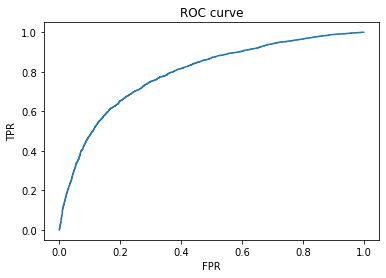

In [204]:
predictions = gridnlr.predict_proba(X_test_std)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

###### Performance Evaluvation

The recall for Logistic is 0.68 for class 1 which is pretty less as compared to other models run on the data.

The ROC as expected is higher as compared to Gausssian Naïve Bayes and gives us a idea that tree based model performs better than probability based approach

###### Hyperparameter Tuning
 
The hyperparameters choosed for Logistic Regression  are:

solver - The algorithm used for optimization. Usually lfgs is used for small datasets while sag is used for large datasets

C - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

## Deep Learning

In [185]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.regularizers import l1,l2

def dnn_model_0(activation_in='relu',activation_out='relu',nodes=6,optimizer ='adam',kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)):
    model = Sequential()
    model.add(Dense(nodes, activation=activation_in, kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001),input_shape=(11, )))
    model.add(Dense(1, activation=activation_out))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=dnn_model_0) 


In [187]:
optimizers = ['adam']
kernel_regularizer=[l1(0.01),l2(0.01)]
bias_regularizer = [l1(0.01),l2(0.01)]
epochs = [5,10]
batches = [2,3]
nodes = [6,10]
activation_out= ['sigmoid'] 
activation_in = ['sigmoid','relu']
param_grid = dict(epochs=epochs, batch_size=batches,optimizer = optimizers,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,nodes=nodes,activation_out=activation_out,activation_in=activation_in)
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv = 3)
grid_result = grid.fit(X_train_le, y_train_le)

Epoch 1/5
26093/26093 [==============================] - 7s 270us/step - loss: 0.5856 - accuracy: 0.7183
Epoch 2/5
26093/26093 [==============================] - 7s 268us/step - loss: 0.5713 - accuracy: 0.7251
Epoch 3/5
26093/26093 [==============================] - 7s 262us/step - loss: 0.5700 - accuracy: 0.7247
Epoch 4/5
26093/26093 [==============================] - 7s 258us/step - loss: 0.5687 - accuracy: 0.7264
Epoch 5/5
13047/13047 [==============================] - 1s 96us/step
Epoch 1/5
26093/26093 [==============================] - 7s 276us/step - loss: 0.5901 - accuracy: 0.7107
Epoch 2/5
26093/26093 [==============================] - 7s 271us/step - loss: 0.5715 - accuracy: 0.7221
Epoch 3/5
26093/26093 [==============================] - 7s 271us/step - loss: 0.5699 - accuracy: 0.7225
Epoch 4/5
26093/26093 [==============================] - 7s 271us/step - loss: 0.5693 - accuracy: 0.7241
Epoch 5/5
13047/13047 [==============================] - 1s 101us/step
Epoch 1/5
26094/260

26094/26094 [==============================] - 7s 269us/step - loss: 0.5596 - accuracy: 0.7312
Epoch 5/10
26094/26094 [==============================] - 7s 266us/step - loss: 0.5587 - accuracy: 0.7306
Epoch 6/10
26094/26094 [==============================] - 7s 265us/step - loss: 0.5581 - accuracy: 0.7308
Epoch 7/10
26094/26094 [==============================] - 7s 266us/step - loss: 0.5579 - accuracy: 0.7317
Epoch 8/10
26094/26094 [==============================] - 7s 265us/step - loss: 0.5574 - accuracy: 0.7308
Epoch 9/10
26094/26094 [==============================] - 7s 265us/step - loss: 0.5574 - accuracy: 0.7303
Epoch 10/10
13046/13046 [==============================] - 1s 96us/step
Epoch 1/10
26093/26093 [==============================] - 7s 272us/step - loss: 0.5950 - accuracy: 0.7133
Epoch 2/10
26093/26093 [==============================] - 7s 268us/step - loss: 0.5717 - accuracy: 0.7251
Epoch 3/10
26093/26093 [==============================] - 7s 268us/step - loss: 0.5693 - ac

13047/13047 [==============================] - 1s 93us/step
Epoch 1/5
26093/26093 [==============================] - 7s 263us/step - loss: 0.5936 - accuracy: 0.7024
Epoch 2/5
26093/26093 [==============================] - 7s 259us/step - loss: 0.5719 - accuracy: 0.7234
Epoch 3/5
26093/26093 [==============================] - 7s 258us/step - loss: 0.5704 - accuracy: 0.7223
Epoch 4/5
26093/26093 [==============================] - 7s 265us/step - loss: 0.5692 - accuracy: 0.7238
Epoch 5/5
13047/13047 [==============================] - 1s 113us/step
Epoch 1/5
26094/26094 [==============================] - 7s 279us/step - loss: 0.5852 - accuracy: 0.7154
Epoch 2/5
26094/26094 [==============================] - 7s 275us/step - loss: 0.5647 - accuracy: 0.7302
Epoch 3/5
26094/26094 [==============================] - 7s 266us/step - loss: 0.5639 - accuracy: 0.7294
Epoch 4/5
26094/26094 [==============================] - 7s 263us/step - loss: 0.5628 - accuracy: 0.7288
Epoch 5/5
13046/13046 [======

13046/13046 [==============================] - 1s 96us/step
Epoch 1/5
26093/26093 [==============================] - 5s 179us/step - loss: 0.5902 - accuracy: 0.7121
Epoch 2/5
26093/26093 [==============================] - 5s 175us/step - loss: 0.5705 - accuracy: 0.7260
Epoch 3/5
26093/26093 [==============================] - 5s 175us/step - loss: 0.5688 - accuracy: 0.7244
Epoch 4/5
26093/26093 [==============================] - 5s 175us/step - loss: 0.5678 - accuracy: 0.7251
Epoch 5/5
13047/13047 [==============================] - 1s 64us/step
Epoch 1/5
26093/26093 [==============================] - 5s 179us/step - loss: 0.5905 - accuracy: 0.7137
Epoch 2/5
26093/26093 [==============================] - 5s 174us/step - loss: 0.5723 - accuracy: 0.7239
Epoch 3/5
26093/26093 [==============================] - 4s 171us/step - loss: 0.5703 - accuracy: 0.7238
Epoch 4/5
26093/26093 [==============================] - 4s 171us/step - loss: 0.5696 - accuracy: 0.7214
Epoch 5/5
13047/13047 [=======

26094/26094 [==============================] - 5s 174us/step - loss: 0.5637 - accuracy: 0.7294
Epoch 3/10
26094/26094 [==============================] - 5s 177us/step - loss: 0.5616 - accuracy: 0.7302
Epoch 4/10
26094/26094 [==============================] - 5s 181us/step - loss: 0.5607 - accuracy: 0.7303
Epoch 5/10
26094/26094 [==============================] - 5s 185us/step - loss: 0.5596 - accuracy: 0.7319
Epoch 6/10
26094/26094 [==============================] - 5s 175us/step - loss: 0.5587 - accuracy: 0.7311
Epoch 7/10
26094/26094 [==============================] - 5s 173us/step - loss: 0.5584 - accuracy: 0.7304
Epoch 8/10
26094/26094 [==============================] - 5s 173us/step - loss: 0.5578 - accuracy: 0.7308
Epoch 9/10
26094/26094 [==============================] - 5s 173us/step - loss: 0.5573 - accuracy: 0.7312
Epoch 10/10
13046/13046 [==============================] - 1s 66us/step
Epoch 1/10
26093/26093 [==============================] - 5s 198us/step - loss: 0.5892 - ac

Epoch 5/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5688 - accuracy: 0.7240
Epoch 6/10
26093/26093 [==============================] - 5s 175us/step - loss: 0.5682 - accuracy: 0.7237
Epoch 7/10
26093/26093 [==============================] - 5s 175us/step - loss: 0.5677 - accuracy: 0.7241
Epoch 8/10
26093/26093 [==============================] - 5s 175us/step - loss: 0.5672 - accuracy: 0.7231
Epoch 9/10
26093/26093 [==============================] - 5s 175us/step - loss: 0.5668 - accuracy: 0.7239
Epoch 10/10
13047/13047 [==============================] - 1s 64us/step
Epoch 1/10
26094/26094 [==============================] - 5s 178us/step - loss: 0.5875 - accuracy: 0.7190
Epoch 2/10
26094/26094 [==============================] - 5s 174us/step - loss: 0.5654 - accuracy: 0.7287
Epoch 3/10
26094/26094 [==============================] - 5s 174us/step - loss: 0.5632 - accuracy: 0.7309
Epoch 4/10
26094/26094 [==============================] - 5s 174us/step - loss: 

26093/26093 [==============================] - 7s 283us/step - loss: 0.5548 - accuracy: 0.7294
Epoch 9/10
26093/26093 [==============================] - 7s 272us/step - loss: 0.5547 - accuracy: 0.7300
Epoch 10/10
13047/13047 [==============================] - 1s 95us/step
Epoch 1/10
26093/26093 [==============================] - 7s 266us/step - loss: 0.5801 - accuracy: 0.7212
Epoch 2/10
26093/26093 [==============================] - 7s 279us/step - loss: 0.5623 - accuracy: 0.7297
Epoch 3/10
26093/26093 [==============================] - 7s 280us/step - loss: 0.5602 - accuracy: 0.7306
Epoch 4/10
26093/26093 [==============================] - 7s 280us/step - loss: 0.5592 - accuracy: 0.7303
Epoch 5/10
26093/26093 [==============================] - 7s 282us/step - loss: 0.5587 - accuracy: 0.7317
Epoch 6/10
26093/26093 [==============================] - 7s 284us/step - loss: 0.5580 - accuracy: 0.7302
Epoch 7/10
26093/26093 [==============================] - 7s 275us/step - loss: 0.5577 - ac

26093/26093 [==============================] - 7s 269us/step - loss: 0.5645 - accuracy: 0.7238
Epoch 3/5
26093/26093 [==============================] - 7s 272us/step - loss: 0.5607 - accuracy: 0.7270
Epoch 4/5
26093/26093 [==============================] - 7s 262us/step - loss: 0.5566 - accuracy: 0.7304
Epoch 5/5
13047/13047 [==============================] - 1s 96us/step
Epoch 1/5
26093/26093 [==============================] - 7s 276us/step - loss: 0.5887 - accuracy: 0.7094
Epoch 2/5
26093/26093 [==============================] - 7s 266us/step - loss: 0.5646 - accuracy: 0.7286
Epoch 3/5
26093/26093 [==============================] - 7s 265us/step - loss: 0.5619 - accuracy: 0.7280
Epoch 4/5
26093/26093 [==============================] - 7s 271us/step - loss: 0.5606 - accuracy: 0.7281
Epoch 5/5
13047/13047 [==============================] - 1s 95us/step
Epoch 1/5
26094/26094 [==============================] - 7s 270us/step - loss: 0.5723 - accuracy: 0.7248
Epoch 2/5
26094/26094 [=======

26094/26094 [==============================] - 7s 283us/step - loss: 0.5504 - accuracy: 0.7381
Epoch 7/10
26094/26094 [==============================] - 7s 261us/step - loss: 0.5496 - accuracy: 0.7370
Epoch 8/10
26094/26094 [==============================] - 7s 251us/step - loss: 0.5492 - accuracy: 0.7382
Epoch 9/10
26094/26094 [==============================] - 7s 262us/step - loss: 0.5490 - accuracy: 0.7358
Epoch 10/10
13046/13046 [==============================] - 2s 145us/step
Epoch 1/5
26093/26093 [==============================] - 7s 280us/step - loss: 0.5876 - accuracy: 0.7111
Epoch 2/5
26093/26093 [==============================] - 7s 268us/step - loss: 0.5624 - accuracy: 0.7289
Epoch 3/5
26093/26093 [==============================] - 6s 246us/step - loss: 0.5590 - accuracy: 0.7308
Epoch 4/5
26093/26093 [==============================] - 6s 243us/step - loss: 0.5572 - accuracy: 0.7318
Epoch 5/5
13047/13047 [==============================] - 1s 111us/step
Epoch 1/5
26093/26093 [

26093/26093 [==============================] - 5s 191us/step - loss: 0.5579 - accuracy: 0.7299
Epoch 10/10
13047/13047 [==============================] - 1s 83us/step
Epoch 1/10
26094/26094 [==============================] - 6s 222us/step - loss: 0.5810 - accuracy: 0.7171
Epoch 2/10
26094/26094 [==============================] - 5s 194us/step - loss: 0.5539 - accuracy: 0.7361
Epoch 3/10
26094/26094 [==============================] - 5s 175us/step - loss: 0.5516 - accuracy: 0.7349
Epoch 4/10
26094/26094 [==============================] - 5s 177us/step - loss: 0.5505 - accuracy: 0.7353
Epoch 5/10
26094/26094 [==============================] - 5s 176us/step - loss: 0.5499 - accuracy: 0.7347
Epoch 6/10
26094/26094 [==============================] - 5s 179us/step - loss: 0.5492 - accuracy: 0.7360
Epoch 7/10
26094/26094 [==============================] - 5s 181us/step - loss: 0.5489 - accuracy: 0.7361
Epoch 8/10
26094/26094 [==============================] - 5s 176us/step - loss: 0.5481 - ac

26093/26093 [==============================] - 6s 220us/step - loss: 0.5933 - accuracy: 0.7156
Epoch 2/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5682 - accuracy: 0.7290
Epoch 3/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5638 - accuracy: 0.7298
Epoch 4/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5617 - accuracy: 0.7303
Epoch 5/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5605 - accuracy: 0.7308
Epoch 6/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5598 - accuracy: 0.7303
Epoch 7/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5592 - accuracy: 0.7303
Epoch 8/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5586 - accuracy: 0.7314
Epoch 9/10
26093/26093 [==============================] - 5s 176us/step - loss: 0.5581 - accuracy: 0.7318
Epoch 10/10
13047/13047 [==============================] 

In [197]:
print(grid_result.best_params_)

{'activation_in': 'relu', 'activation_out': 'sigmoid', 'batch_size': 3, 'bias_regularizer': <keras.regularizers.L1L2 object at 0x7fbd729b4810>, 'epochs': 10, 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7fbd67c24690>, 'nodes': 10, 'optimizer': 'adam'}


In [201]:
dnn_0_df = pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_in,param_activation_out,param_batch_size,param_bias_regularizer,param_epochs,param_kernel_regularizer,param_nodes,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,35.334807,0.565471,1.312906,0.033731,sigmoid,sigmoid,2,<keras.regularizers.L1L2 object at 0x7fbd67c24...,5,<keras.regularizers.L1L2 object at 0x7fbd67c24...,6,adam,"{'activation_in': 'sigmoid', 'activation_out':...",0.727370,0.728827,0.717845,0.724681,0.004870,63
1,35.277851,0.233483,1.297837,0.005833,sigmoid,sigmoid,2,<keras.regularizers.L1L2 object at 0x7fbd67c24...,5,<keras.regularizers.L1L2 object at 0x7fbd67c24...,10,adam,"{'activation_in': 'sigmoid', 'activation_out':...",0.728750,0.731816,0.715775,0.725447,0.006953,57
2,36.365669,0.355590,1.384942,0.028793,sigmoid,sigmoid,2,<keras.regularizers.L1L2 object at 0x7fbd67c24...,5,<keras.regularizers.L1L2 object at 0x7fbd729b4...,6,adam,"{'activation_in': 'sigmoid', 'activation_out':...",0.727600,0.732812,0.715008,0.725141,0.007474,62
3,35.587151,0.666420,1.332699,0.046095,sigmoid,sigmoid,2,<keras.regularizers.L1L2 object at 0x7fbd67c24...,5,<keras.regularizers.L1L2 object at 0x7fbd729b4...,10,adam,"{'activation_in': 'sigmoid', 'activation_out':...",0.727677,0.731816,0.716158,0.725217,0.006625,61
4,70.407590,0.916281,1.336711,0.043508,sigmoid,sigmoid,2,<keras.regularizers.L1L2 object at 0x7fbd67c24...,10,<keras.regularizers.L1L2 object at 0x7fbd67c24...,6,adam,"{'activation_in': 'sigmoid', 'activation_out':...",0.731892,0.733885,0.719608,0.728462,0.006313,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,29.617394,0.532675,1.316678,0.053347,relu,sigmoid,3,<keras.regularizers.L1L2 object at 0x7fbd729b4...,5,<keras.regularizers.L1L2 object at 0x7fbd729b4...,10,adam,"{'activation_in': 'relu', 'activation_out': 's...",0.734728,0.736108,0.722674,0.731170,0.006034,31
60,57.608088,0.443795,1.277432,0.025426,relu,sigmoid,3,<keras.regularizers.L1L2 object at 0x7fbd729b4...,10,<keras.regularizers.L1L2 object at 0x7fbd67c24...,6,adam,"{'activation_in': 'relu', 'activation_out': 's...",0.733042,0.738177,0.725280,0.732167,0.005302,22
61,50.925871,4.893235,1.068098,0.186426,relu,sigmoid,3,<keras.regularizers.L1L2 object at 0x7fbd729b4...,10,<keras.regularizers.L1L2 object at 0x7fbd67c24...,10,adam,"{'activation_in': 'relu', 'activation_out': 's...",0.737411,0.736261,0.728269,0.733981,0.004066,1
62,48.948569,1.037165,0.930075,0.016952,relu,sigmoid,3,<keras.regularizers.L1L2 object at 0x7fbd729b4...,10,<keras.regularizers.L1L2 object at 0x7fbd729b4...,6,adam,"{'activation_in': 'relu', 'activation_out': 's...",0.737794,0.735495,0.725893,0.733061,0.005154,11


0.8024112793549595


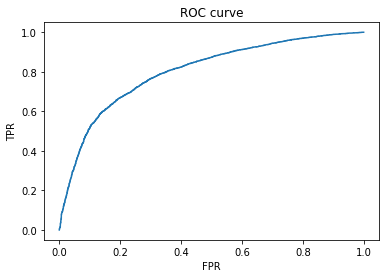

In [203]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
predictions = grid_result.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [211]:
from keras import metrics
def dnn_model_1(activation_in='relu',activation_out='relu',nodes=6,optimizer ='adam',kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)):
    model = Sequential()
    model.add(Dense(nodes, activation=activation_in, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,input_shape=(11, )))
    model.add(Dense(nodes, activation=activation_in, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer))
    model.add(Dense(1, activation=activation_out))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',metrics.FalseNegatives()])
    return model

model1 = KerasClassifier(build_fn=dnn_model_1) 



In [212]:
epochs = [10]
batches = [3]
nodes = [10]
activation_out= ['sigmoid'] 
activation_in = ['sigmoid','relu']
param_grid = dict(epochs=epochs, batch_size=batches,optimizer = optimizers,nodes=nodes,activation_out=activation_out,activation_in=activation_in)
grid1 = GridSearchCV(estimator=model1, param_grid=param_grid,cv = 3)
grid_result1 = grid1.fit(X_train_le, y_train_le)

Epoch 1/10
26093/26093 [==============================] - 6s 225us/step - loss: 0.6232 - accuracy: 0.7107 - false_negatives_1: 4568.0000
Epoch 2/10
26093/26093 [==============================] - 6s 223us/step - loss: 0.5946 - accuracy: 0.7236 - false_negatives_1: 4269.0000
Epoch 3/10
26093/26093 [==============================] - 6s 230us/step - loss: 0.5900 - accuracy: 0.7265 - false_negatives_1: 4263.0000
Epoch 4/10
26093/26093 [==============================] - 6s 217us/step - loss: 0.5867 - accuracy: 0.7239 - false_negatives_1: 4313.0000
Epoch 5/10
26093/26093 [==============================] - 6s 214us/step - loss: 0.5836 - accuracy: 0.7245 - false_negatives_1: 4251.0000
Epoch 6/10
26093/26093 [==============================] - 6s 214us/step - loss: 0.5809 - accuracy: 0.7249 - false_negatives_1: 4252.0000
Epoch 7/10
26093/26093 [==============================] - 6s 214us/step - loss: 0.5790 - accuracy: 0.7244 - false_negatives_1: 4228.0000
Epoch 8/10
26093/26093 [=================

0.8055166063528343


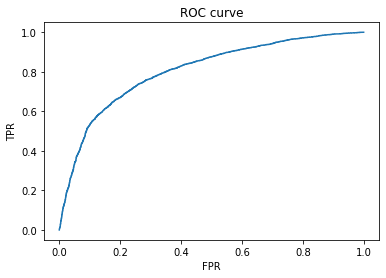

In [213]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
predictions = grid_result1.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [239]:
dnn_1_df = pd.DataFrame(grid_result1.cv_results_)

In [214]:
def dnn_model_2(activation_in='relu',activation_out='relu',nodes=6,optimizer ='adam',kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001)):
    model = Sequential()
    model.add(Dense(nodes, activation=activation_in, kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001),input_shape=(11, )))
    model.add(Dense(nodes, activation=activation_in, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer))
    model.add(Dense(nodes, activation=activation_in, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer))
    model.add(Dense(1, activation=activation_out))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',metrics.FalseNegatives()])
    return model

model2 = KerasClassifier(build_fn=dnn_model_2) 



In [216]:

grid2 = GridSearchCV(estimator=model2, param_grid=param_grid)
grid_result2 = grid2.fit(X_train_le, y_train_le)

Epoch 1/10
26093/26093 [==============================] - 6s 223us/step - loss: 0.6208 - accuracy: 0.7088 - false_negatives_8: 4170.0000
Epoch 2/10
26093/26093 [==============================] - 6s 222us/step - loss: 0.5928 - accuracy: 0.7254 - false_negatives_8: 4194.0000
Epoch 3/10
26093/26093 [==============================] - 6s 215us/step - loss: 0.5863 - accuracy: 0.7257 - false_negatives_8: 4250.0000
Epoch 4/10
26093/26093 [==============================] - 6s 213us/step - loss: 0.5827 - accuracy: 0.7241 - false_negatives_8: 4274.0000
Epoch 5/10
26093/26093 [==============================] - 6s 218us/step - loss: 0.5812 - accuracy: 0.7245 - false_negatives_8: 4262.0000
Epoch 6/10
26093/26093 [==============================] - 6s 216us/step - loss: 0.5797 - accuracy: 0.7245 - false_negatives_8: 4270.0000
Epoch 7/10
26093/26093 [==============================] - 5s 209us/step - loss: 0.5784 - accuracy: 0.7246 - false_negatives_8: 4288.0000
Epoch 8/10
26093/26093 [=================

0.8063913448815109


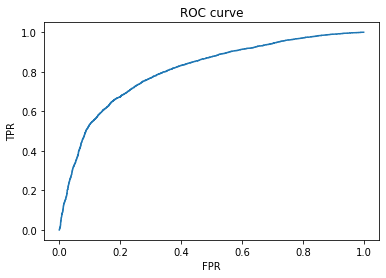

In [217]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
predictions = grid_result2.predict_proba(X_test_le)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [240]:
dnn_2_df = pd.DataFrame(grid_result2.cv_results_)

In [223]:
pred_ann0 = grid_result.predict(X_test_le)
pred_ann1 = grid_result1.predict(X_test_le)
pred_ann2 = grid_result2.predict(X_test_le)

In [320]:
print("Best train accuracy :",grid_result.best_score_)
print("ANN with no hidden layers")
print(classification_report(y_test,pred_ann0))

Best train accuracy : 0.7339805830374748
ANN with no hidden layers
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      4896
           1       0.74      0.72      0.73      4890

    accuracy                           0.73      9786
   macro avg       0.73      0.73      0.73      9786
weighted avg       0.73      0.73      0.73      9786



In [321]:
print("Best train accuracy :",grid_result1.best_score_)
print("ANN with 1 hidden layers")
print(classification_report(y_test,pred_ann1))

Best train accuracy : 0.7349770213001896
ANN with 1 hidden layers
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      4896
           1       0.76      0.69      0.73      4890

    accuracy                           0.74      9786
   macro avg       0.74      0.74      0.74      9786
weighted avg       0.74      0.74      0.74      9786



In [322]:
print("Best train accuracy :",grid_result2.best_score_)
print("ANN with 2 hidden layers")
print(classification_report(y_test,pred_ann2))

Best train accuracy : 0.732958599724024
ANN with 2 hidden layers
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      4896
           1       0.75      0.71      0.73      4890

    accuracy                           0.74      9786
   macro avg       0.74      0.74      0.74      9786
weighted avg       0.74      0.74      0.74      9786



###### Performance Evaluvation
The accuracies increase from 73 % to 74% when we move from 0 hidden layers to 2 hidden layers. The highest f1-score  for class 1 was observed for model with 0 hidden layers while hidden layers 1 and 2 provide higher precision and accuracies. Keeping all the trade offs in mind ANN with hidden layer 1 was best

###### Overfitting and Underfitting
The training and testing accuracies of ANN with no hidden layerr, 1 hidden layer and 2 hidden layer are almost same. Thus, we can say that the models are not overfitting

###### Hyperparameter Tuning
Number of nodes : Nodes or neurons are computational units which have one or many input connections and produce some output. for this assignment I have experimented with 6 and 10 nodes. I wanted to experiment if increasing num of nodes improves output. After running 64 models with 3 cv cross validation I found that n =10 gives best results thus for both ANN with 1 hidden layer and 2 I have just used n =10

Number of epochs : Represents the number of times the training data passes through the NN. for the first I experimented with 5 and 10 epochs. 10 epochs gave best performace and was used for further ANN1 and ANN2

Batch Size : Represents the number of training examples proceesed at a time. for the first I experimented with 2 and 3 Batch Size. 3 Batch Size gave best performace and was used for further ANN1 and ANN2

Also, for this model I have experimented with sigmoid and relu activation input functions and sigmoid activation output function. The optimizer choosed was adam as it gave best results in initial experimentation. 
\
bias_regularizer and kernel_regulizer were experimented with values l1(0.01) and l2(0.01) and l1(0.01) gave best results to take care of bias

### Decision Tree

In [227]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [234]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [5, 2],
              'min_samples_leaf': [3,5],
              'max_leaf_nodes': [5, 10]}
gridclf = GridSearchCV(clf, param_grid, cv=3, scoring='f1')
gridclf.fit(X_train_le, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 2],
                         'max_leaf_nodes': [5, 10],
    

In [319]:
gridclf.best_score_

0.7281528727981592

In [235]:
from sklearn.metrics import classification_report
pred_clf = gridclf.predict(X_test_le)
print(classification_report(pred_clf,y_test))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73      4872
           1       0.74      0.73      0.74      4914

    accuracy                           0.73      9786
   macro avg       0.73      0.73      0.73      9786
weighted avg       0.73      0.73      0.73      9786



0.7931496601708169


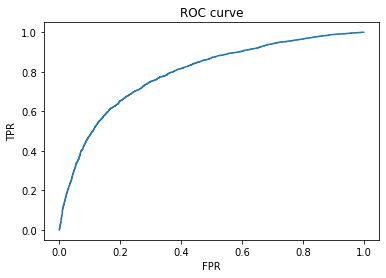

In [317]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
predictions = gridnlr.predict_proba(X_test_std)

print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

##### Performance Evaluvation
The recall for decision tree is 0.74 for class 1 which is highest from all models implemented, however the accuracy and precision for this model are less than ANN. Also the model is 73% accurate. 

The ROC is a little lower as compared to ANN and gives us a idea that ANN performs better in task of class seperation

##### Overfitting
The training accuracy obtained through grid search cv after 3 fold cross validation is almost equal to the testing accuracy. Thus we can say the model is not overfitting.

###### Hyperparameter Tuning
criterion - Measure the quality of split based on either i. or entropy,for information gained 

max_depth - The maximum depth of the tree

min_samples_leaf - Min number of instances present for leaf nodes

max_leaf_nodes - The maximum number of parent nodes in the tree


In [316]:
gridclfimp =[]
for col,imp in enumerate(gridclf.best_estimator_.feature_importances_):
    gridclfimp.append(imp)
for col,dt,lr in zip(X_train.columns,gridclfimp,gridnlr.best_estimator_.coef_[0]):
    print(col,dt,lr)

Age 0.12148661327265546 0.8281739366219739
Alcohol 0.0 0.3215550300559067
Cholesterol 0.06669982606653707 -0.1253406801427169
Exercise 0.0 0.007334554015846373
Gender 0.0 0.1715074869528097
Glucose 0.0 0.5054163639469295
Height 0.0 -0.08727324588012994
High Blood Pressure 0.8118135606608075 0.359725572065455
Low Blood Pressure 0.0 0.0041451012900244255
Smoke 0.0 -0.15131768019261344


As we can see from the above cell Age which is considered the most import feature in Logistic Regression is second most important in Decision tree while the second most important feature in Logistic Regression high blood pressure is most important in Decision Tree

### Master Table

The dataframes storing the performance measure in HW3 is imported in this file using the pickle library

In [236]:
import pickle
with open('HW_3_performance', 'rb') as f:
    el_df = pickle.load(f)
    rf_df= pickle.load(f)
    lsvm_df = pickle.load(f)
    nlsvm_df = pickle.load(f)
    knn_train = pickle.load(f)
    knn_test = pickle.load(f)

In [242]:
el_t = el_df.loc[:,['mean_fit_time','params','mean_test_score']]
rf_t = rf_df.loc[:,['mean_fit_time','params','mean_test_score']]
lsvm_t = lsvm_df.loc[:,['mean_fit_time','params','mean_test_score']]
nlsvm_t = nlsvm_df.loc[:,['mean_fit_time','params','mean_test_score']]
dnn_2_t = dnn_2_df.loc[:,['mean_fit_time','params','mean_test_score']]
dnn_1_t = dnn_1_df.loc[:,['mean_fit_time','params','mean_test_score']]
dnn_0_t = dnn_0_df.loc[:,['mean_fit_time','params','mean_test_score']]

In [245]:
el_t['model'] = "Ensemble Learning"
rf_t['model'] = "Random Forest"
lsvm_t['model'] = "Linear SVM"
nlsvm_t['model'] = "Non Linear SVM"
dnn_2_t['model'] = "ANN2"
dnn_1_t['model'] = "ANN1"
dnn_0_t['model'] = "ANN0"

In [253]:
param = [{'neighbours':i} for i in range(1,50)]
knn = pd.DataFrame({'params':param,'mean_test_score':knn_test})
knn['mean_fit_time']="Approx 5 min"
knn['model'] = "K Nearest Neighbours"

In [254]:
merged_df = pd.concat([el_t, rf_t,lsvm_t,nlsvm_t,dnn_2_t,dnn_1_t,dnn_0_t,knn])

In [260]:
merged_df=merged_df.sort_values(by=['mean_test_score'],ascending=False)

In [262]:
print("model performance master table : ")
merged_df

model performance master table : 


,mean_fit_time,mean_test_score,model,params
44,Approx 5 min,72.549803,K Nearest Neighbours,{'neighbours': 45}
46,Approx 5 min,72.544695,K Nearest Neighbours,{'neighbours': 47}
45,Approx 5 min,72.537029,K Nearest Neighbours,{'neighbours': 46}
48,Approx 5 min,72.529366,K Nearest Neighbours,{'neighbours': 49}
35,Approx 5 min,72.529365,K Nearest Neighbours,{'neighbours': 36}
...,...,...,...,...
2,14.1666,0.624323,Linear SVM,"{'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'p..."
8,14.2518,0.593434,Linear SVM,"{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': ..."
7,13.5401,0.593434,Linear SVM,"{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': ..."
6,8.79627,0.498186,Linear SVM,"{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': ..."


The model that provides highest training accuracy is K nearest neighbours with 45 neighbours. The 

## Predictions

In [294]:
test_data = pd.read_csv('Disease Prediction Testing.csv')

In [295]:
test_data.loc[(test_data['High Blood Pressure']>200),'High Blood Pressure'] = median_HBP
test_data.loc[(test_data['High Blood Pressure']<80),'High Blood Pressure'] = median_HBP
test_data.loc[(test_data['Low Blood Pressure']>175),'Low Blood Pressure'] = median_LBP
test_data.loc[(test_data['Low Blood Pressure']<40),'Low Blood Pressure'] = median_LBP
test_data.loc[(test_data['Weight']<40),'Weight'] = median_weight

In [296]:
le_test = test_data.copy()
oh_test =  test_data.copy()
le_test.drop(['ID'],axis =1,inplace = True)
oh_test.drop(['ID'],axis =1, inplace = True)
for col in le_test.columns:
    if le_test[col].dtypes == np.object:
        print(col)
        le_test[col] = le_test[col].astype(str)
        csv_le1 = le.fit(csv_data[col])
        le_test[col] = csv_le1.transform(le_test[col])

Gender
Cholesterol
Glucose


In [297]:
oh_test = oh_ss_pc.transform(oh_test)
le_test = numeric_transformer.transform(le_test)

In [298]:
DT = gridclf.predict(le_test)
LR = gridnlr.predict(oh_test)
ANN0p = grid_result.predict(le_test)
ANN1p = grid_result1.predict(le_test)
ANN2p =grid_result2.predict(le_test)

In [299]:
ANN2=[]
ANN1=[]
ANN0=[]
for a in ANN2p:
    ANN2.append(a[0])
for a in ANN1p:
    ANN1.append(a[0])
for a in ANN0p:
    ANN0.append(a[0])

In [300]:
prediction_df = pd.DataFrame({'ID':test_data['ID'],"DT":DT,"LR":LR,"ANN0":ANN0,"ANN1":ANN1,"ANN2":ANN2})

In [301]:
prediction_df.to_csv("prediction.csv",index = False)